# Use D3D-loader to implement LSTM-style disruption prediction


This notebook illustrates how to use an LSTM to predict disruptions.
It operates on a dataset that has been compiled using https://github.com/PPPLDeepLearning/dataset_D3D_100
The code for the `d3d_loaders` package is here: https://github.com/PlasmaControl/d3d_loaders

Note that the interface to `d3d_loaders` is still in flux (as of 2023-03), so some function may be 
out of date. (Either a different name, or slightly different arguments).


In [1]:
from os.path import join 
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
from time import perf_counter

In [2]:
import logging 
logging.basicConfig(filename="tFRNN-test.log",
                 filemode='a',
                 format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                 datefmt='%H:%M:%S',
                 level=logging.DEBUG)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [4]:
import sys
sys.path.append("/home/rkube/repos/d3d_loaders")

In [5]:
from d3d_loaders.time_sampling import sampler_causal, sampler_linearip
from d3d_loaders.standardizers import standardizer_mean_std
from d3d_loaders.d3d_loaders import Multishot_dataset
from d3d_loaders.samplers import BatchedSampler, BatchedSampler_multi, collate_fn_batched
#from d3d_loaders.samplers import RandomBatchedSampler_multishot, collate_fn_random_batch_seq_multi

In [6]:
# ML parameters
seq_length = 128
batch_size = 16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Fetch the dataset definition.
# The dataset can be compiled with the code in
# https://github.com/PPPLDeepLearning/dataset_D3D_100
datapath = "/projects/FRNN/dataset_D3D_100/D3D_100"

# fetch dataset definition for list of predictors.
with open(join(datapath, "..", "d3d_100.yaml"), "r") as fp:
    d3d_100 = yaml.safe_load(fp)

In [8]:
# Next we need to instantiate samplers.
# These are used when reading the signal data from HDF5 and resample the raw MDS/PTdata signals
# onto a common time-base
# Each shot has a different length. We therefore create separate re-samplers for each shot
# that will operate on the duration for each specific shot.
#
# The times t_max and t_min have been calculated when the dataset was instantiated.

# Load tmax from yaml
with open(join(datapath, "..", "shots_t_min_max.yaml"), "r") as fp:
    t_min_max_dict = yaml.safe_load(fp)

# The d3d_datasets expects a that the samplers for each shot are passed as a dictionary.
sampler_pred_dict = {}
sampler_targ_dict = {}

# Instantiate the samplers and store in the dict.
for shotnr in d3d_100["shots"].keys():
    tmin = t_min_max_dict[shotnr]["tmin"]
    tmax = t_min_max_dict[shotnr]["tmax"]
    sampler_pred_dict.update({shotnr: sampler_causal(tmin, tmax, 1.0, t_shift=0.0)})
    sampler_targ_dict.update({shotnr: sampler_linearip(tmin, tmax, 1.0, t_shift=0.0)})

In [9]:
# Signals are to be normalized to a mean and standard deviation that is calculated over all shots
# in the dataset. Again, these have been calculated during dataset instantiation and stored in a yaml file.
# Here we only need to read the results from that file and instantiate a standardizer for each predictor.
  
norm_dict = {}
with open(join(datapath, "..", "normalization.yaml"), "r") as fp:
    normalization = yaml.safe_load(fp)

for k, v in normalization.items():
    norm_dict[k] = standardizer_mean_std(v["mean"], v["std"])
    
# See if normalizers exists for each predictor
for k in d3d_100["predictors"]:
    print(f"{k}: - {norm_dict[k]}")

q95: - standardizer_mean_std, mean=5.184311389923096, std=1.5161405801773071
efsli: - standardizer_mean_std, mean=0.3951151669025421, std=1.5564916133880615
ipspr15V: - standardizer_mean_std, mean=0.7057914733886719, std=1.219893217086792
efsbetan: - standardizer_mean_std, mean=0.4627656936645508, std=2.9649791717529297
efswmhd: - standardizer_mean_std, mean=170089.75, std=295768.5625
dssdenest: - standardizer_mean_std, mean=1.5571290254592896, std=2.655435800552368
pradcore: - standardizer_mean_std, mean=0.0004797014989890158, std=0.001246804022230208
pradedge: - standardizer_mean_std, mean=0.0002682978811208159, std=0.0006586981471627951
bmspinj: - standardizer_mean_std, mean=2864.448486328125, std=2992.5341796875
bmstinj: - standardizer_mean_std, mean=1.866433024406433, std=2.413785934448242
ipsiptargt: - standardizer_mean_std, mean=1.0358558893203735, std=1.052363634109497
ipeecoil: - standardizer_mean_std, mean=-0.08526585251092911, std=0.37374114990234375


In [10]:
# To a random test/train split over the shots.
shot_list = list(d3d_100["shots"].keys())
random.shuffle(shot_list)

# Split
num_shots = len(shot_list)
num_train = 50
num_valid = 10

shots_train = shot_list[:num_train]
shots_valid = shot_list[num_train:num_train + num_valid]

In [11]:
# Create the training set. This can take some time.
ds_train = Multishot_dataset(shots_train, d3d_100["predictors"], ["ttd"],
                             sampler_pred_dict, sampler_targ_dict, norm_dict, datapath, torch.device("cpu"))


In [12]:
shot_length_train = []
for ix, shotnr in enumerate(shots_train):
    shot_length_train.append(ds_train.shot(ix).__len__())
    print(f"shot {shotnr}, length: {shot_length_train[-1]}")

shot 168493, length: 2216
shot 167574, length: 800
shot 168510, length: 2970
shot 168508, length: 6181
shot 167537, length: 5760
shot 167567, length: 700
shot 167555, length: 6040
shot 167501, length: 6770
shot 167571, length: 3180
shot 167554, length: 6160
shot 168543, length: 6931
shot 167612, length: 4674
shot 167500, length: 5181
shot 167497, length: 6563
shot 167586, length: 2867
shot 168445, length: 2476
shot 167601, length: 4400
shot 168546, length: 6051
shot 167562, length: 3731
shot 168551, length: 5960
shot 167516, length: 6160
shot 167485, length: 6020
shot 167526, length: 5780
shot 167502, length: 6260
shot 168550, length: 6207
shot 167560, length: 783
shot 167535, length: 5740
shot 168506, length: 5611
shot 168516, length: 6880
shot 168514, length: 840
shot 167558, length: 5122
shot 167518, length: 6000
shot 167517, length: 6280
shot 167522, length: 5740
shot 167568, length: 2680
shot 167494, length: 3378
shot 167556, length: 5225
shot 168540, length: 6039
shot 168520, len

In [13]:
# Create the validation set and print stats on length
ds_valid = Multishot_dataset(shots_valid, d3d_100["predictors"], ["ttd"],
                             sampler_pred_dict, sampler_targ_dict, norm_dict, datapath, torch.device("cpu"))

In [14]:
shot_length_valid = []
for ix, shotnr in enumerate(shots_valid):
    shot_length_valid.append(ds_valid.shot(ix).__len__())
    print(f"shot {shotnr}, length: {shot_length_valid[-1]}")

shot 167572, length: 5060
shot 167619, length: 4816
shot 167569, length: 2520
shot 167483, length: 6100
shot 167482, length: 5940
shot 167539, length: 6060
shot 168492, length: 2238
shot 167605, length: 6280
shot 167610, length: 1617
shot 167603, length: 6220


Text(0, 0.5, 'log10(TTD)')

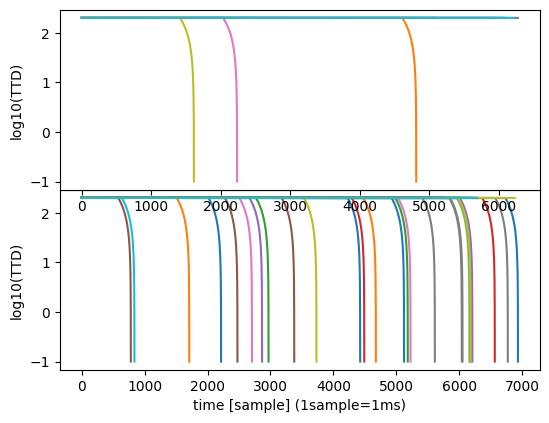

In [15]:
# Plot TTD for test and validation sets
fig = plt.figure()
ax_tr = fig.add_axes([0.2, 0.2, 0.75, 0.375])
ax_vl = fig.add_axes([0.2, 0.575, 0.75, 0.375])


for ix_shot in range(len(ds_train.datasets)):
    ax_tr.plot(ds_train.shot(ix_shot).targets["ttd"].data)
    
for ix_shot in range(len(ds_valid.datasets)):
    ax_vl.plot(ds_valid.shot(ix_shot).targets["ttd"].data)
    
ax_tr.set_xlabel("time [sample] (1sample=1ms)")
ax_tr.set_ylabel("log10(TTD)")
ax_vl.set_ylabel("log10(TTD)")

In [21]:
# Instantiate a loader for the training set.
# This loader picks sequences of size seq_length+1 at random starting points, distributed across shots.
# It picks batch_size sequences at a time.
# Use shuffle=True to shuffle the dataset. Note that the sampler sets a seed for shuffling. We later
# need to update this in every epoch so that the shuffling is differnt in each epoch
sampler_train = BatchedSampler_multi(shot_length_train, seq_length, batch_size, shuffle=True)

loader_train = DataLoader(ds_train,
                          batch_sampler=sampler_train, 
                          collate_fn=collate_fn_batched())

In [22]:
# Verify that we can iterate over all sequences. Print out info on first iteration
out = True
t_start = perf_counter()
for x, y in loader_train:
    if out:
        print(x.shape, y.shape, type(x), x.dtype, type(y), y.dtype)
        out = False
    continue
t_end = perf_counter()
print(f"1 iteration over dataset takes {(t_end - t_start):7.3f}s")

torch.Size([129, 16, 12]) torch.Size([129, 16, 1]) <class 'torch.Tensor'> torch.float32 <class 'torch.Tensor'> torch.float32
1 iteration over dataset takes  83.254s


In [24]:
sampler_valid = BatchedSampler_multi(shot_length_valid, seq_length, batch_size, shuffle=True)

loader_valid = DataLoader(ds_valid,
                          batch_sampler=sampler_valid,
                          collate_fn=collate_fn_batched())

In [25]:
out = True
t_start = perf_counter()

for x, y in loader_valid:
    if out:
        print(x.shape, y.shape, type(x), x.dtype, type(y), y.dtype)
        out = False
    continue
t_end = perf_counter()
print(f"1 iteration over validation dataset takes {(t_end - t_start):7.3f}s")

torch.Size([129, 16, 12]) torch.Size([129, 16, 1]) <class 'torch.Tensor'> torch.float32 <class 'torch.Tensor'> torch.float32
1 iteration over validation dataset takes  16.044s


In [26]:
class my_lstm(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, seq_length, num_layers=2):
        super(my_lstm, self).__init__()
        self.num_classes = num_classes  # Number of output features
        self.input_size = input_size    # Number of features in the input x
        self.hidden_size = hidden_size  # Number of features in hidden state h
        self.seq_length = seq_length  
        self.num_layers = num_layers
        self.device = device
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=False) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc_2 = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        
        hn = hn[-1, ...]    # Take output of the last hidden recurrent layer
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out)  # Final Output
        return out

In [27]:
model = my_lstm(1, len(d3d_100["predictors"]), hidden_size=128, seq_length=seq_length, num_layers=4).to(device)

# Calculate parameters
n_param = 0
for param in model.parameters():
    n_param += param.nelement()
print(f"{n_param} parameters")

485633 parameters


In [28]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
num_epochs = 20

losses_train = np.zeros(num_epochs)
losses_valid = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Remember to update the epoch of the samplers to use a new seed for sample shuffling
    sampler_train.set_epoch(epoch)
    sampler_valid.set_epoch(epoch)

    t_start = perf_counter()
    model.train()

    loss_train = 0.0
    loss_valid = 0.0
    ix_bt = 0
    for inputs, target in loader_train:
        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        output = model(inputs[:-1, :, :])

        loss = loss_fn(output, target[-1,:,:])
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        #print(f"batch {ix_b}: loss = {loss.item()}")
        ix_bt += 1
    
    ix_bv = 0
    with torch.no_grad():
        for inputs, target in loader_valid:
            inputs = inputs.to(device)
            target = target.to(device)
            
            output = model(inputs[:-1, :, :])
        
            loss_valid += loss_fn(output, target[-1, :, :]).item()
            ix_bv += 1
            
    losses_train[epoch] = loss_train / ix_bt / batch_size
    losses_valid[epoch] = loss_valid / ix_bv / batch_size
    t_end = perf_counter()
    t_epoch = t_end - t_start
    
    
    print(f"Epoch {epoch} took {t_epoch:7.3f}s. train loss = {losses_train[epoch]:8.6e}, valid loss =  {losses_valid[epoch]:8.6e}")
        

Look at the performance of the trained model

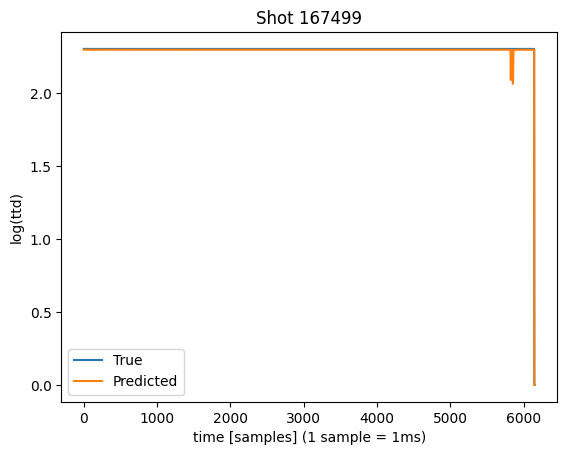

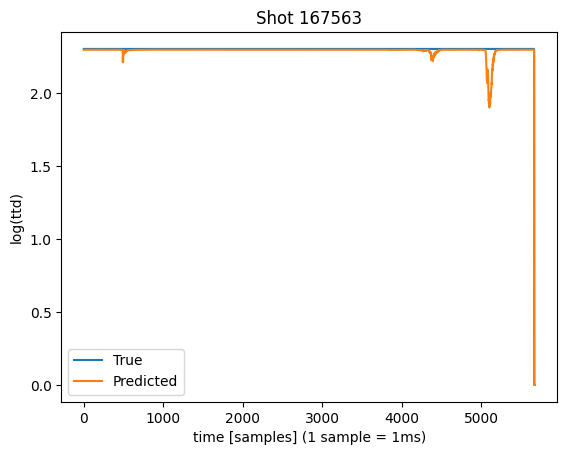

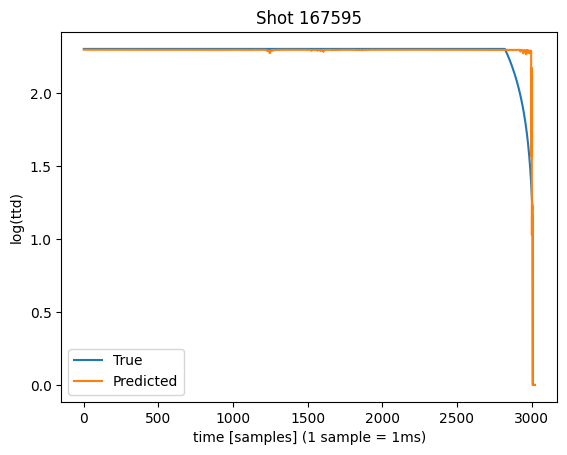

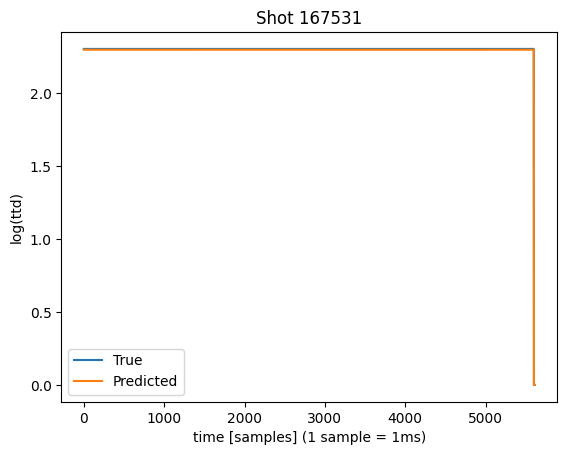

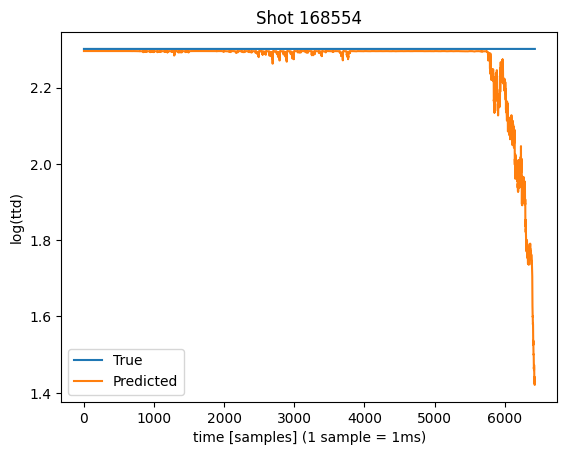

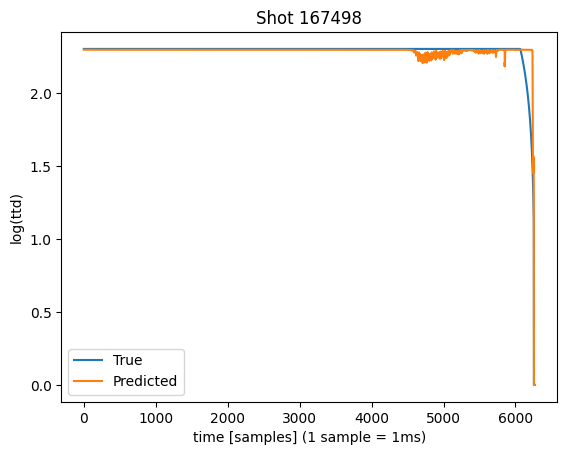

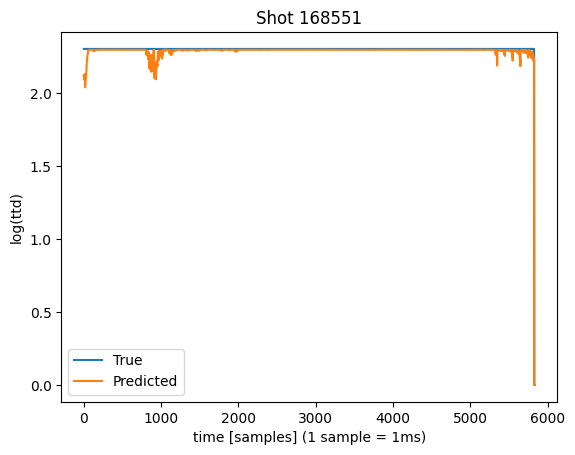

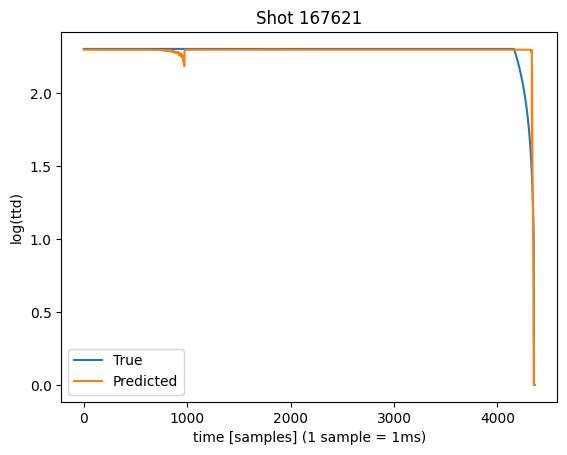

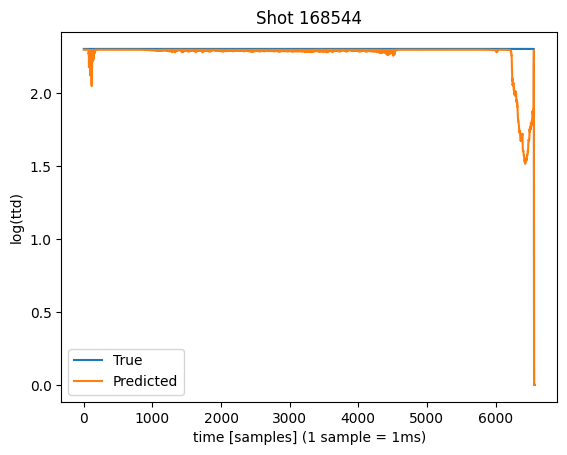

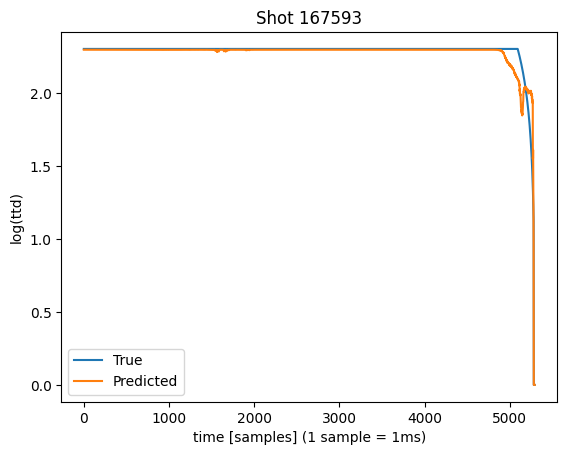

In [43]:
for ix_shot in range(len(ds_valid)):
    loader_seq = DataLoader(ds_valid.shot(ix_shot),
                            batch_sampler=BatchedSampler(shot_length_valid[ix_shot], seq_length, batch_size, shuffle=False)
                            collate_fn=collate_fn_seq_batched())
    
    output_pred = np.zeros(shot_length_valid[ix_shot])
    output_true = np.zeros(shot_length_valid[ix_shot])
    for ix, (x, y) in enumerate(loader_seq):
        inputs = x.to(device)
        output = model(inputs[:-1, :, :])
        # Skip partial batches
        if output.shape[0] == batch_size:
            output_pred[seq_length + (ix * batch_size):seq_length + ((ix + 1) * batch_size)] = output[:, 0].detach().cpu()
            output_true[seq_length + (ix * batch_size):seq_length + ((ix + 1) * batch_size)] = y[-1, :, 0].detach().cpu()
        
    plt.figure()
    plt.plot(output_true[seq_length:], label="True")
    plt.plot(output_pred[seq_length:], label="Predicted")
    plt.title(f"Shot {ds_valid.shot(ix_shot).shotnr}")
    plt.xlabel("time [samples] (1 sample = 1ms)")
    plt.ylabel("log(ttd)")
    plt.legend(loc="lower left")
    plt.savefig(f"plots/FRNN_test_LSTM_{ds_valid.shot(ix_shot).shotnr}.png")